# **Quality Control (QC) and filtering**

---------------------

**Motivation:**

Quality control and filtering are the most important steps of single cell data analysis. Allowing low quality cells into your analysis will compromise/mislead your conclusions by adding meaningless data points to your workflow.
The main sources of low quality cells are
- broken cells for which some of their transcripts get lost
- cells isolated together with too much ambient RNA
- missing cell during isolation (e.g. empty droplet in microfluidic machines)
- multiple cells isolated together (multiplets, usually only two cells - doublets).

Such sources can be identified, for example, through the following quality measures:
- *number of transcripts and number of genes detected per cell*: Droplet-based techniques vary in efficiency in capturing mRNA in each cell. However, a cell that has been correctly isolated will have a relatively high amount of transcripts. Droplets with a low amount of transcripts can be broken cells (containing only a portion of transcripts) or empty droplets (capturing only ambient RNA). Droplets with an unusually high number of transcripts might be multiple cells captured into the same droplet. Usually the number of detected genes grow with the number of transcripts, so we can apply similar arguments as for the number of transcripts.
- *percentage of mitochondrial genes per cell:* Droplets with a high proportion of mitocondrial genes might cells with broken membrane, whose cytoplasmic mRNA has spilled out of the cells, but not the RNA contained into the mitochondria. Thus high percentage of mitochondria indicates possible apoptosis.
- *percentage of ribosomal genes per cell:* High proportions of ribosomal genes in a droplet can be due to the degradation of RNA fragments and increased templating of ribosomal RNA fragments.

To use these quality measures, we will look at their distributions across cells (or genes), and try to identify some thresholds to filter out outlying cells.

---------------------------

**Learning objectives:**

- Understand and discuss QC issues and measures from single cell data
- Explore QC graphs and set filtering tools and thresholds
- Analyze the results of QC filters and evaluate necessity for different filtering 
----------------
**Execution time: 40 minutes**

------------------------------------

## Import the packages and load the data

In [20]:
import scanpy as sc
import pandas as pd
import scvelo as scv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import ipywidgets as widgets

In [21]:
%run '../../Scripts/pythonScripts.py'

In [156]:
sample_2 = sc.read_h5ad('../../Data/notebooks_data/sample_2.h5ad')

We calculate the percentage of ribosomal protein genes and mitochondrial genes into each cell. We look at genes that contain `RPS` or `RPL` and `MT-` into their ID, and calculate their transcript proportion into each cell. We save the result as an observation into `.obs['perc_rp']` and `.obs['perc_mito']`

In [157]:
import re
RP = [ re.match("^RP[SL]",i)!=None for i in sample_2.var_names]
perc_rp = np.sum( sample_2[:,RP].X, 1 ) / np.sum( sample_2.X, 1 )
sample_2.obs['perc_rp'] = perc_rp.copy()

In [158]:
MT = ['MT' in i for i in sample_2.var_names]
perc_mito = np.sum( sample_2[:,MT].X, 1 ) / np.sum( sample_2.X, 1 )
sample_2.obs['perc_mito'] = perc_mito.copy()

## Visualize quality measure distributions

We can have a look at quality measures combined together in different ways. A first technique is to look at **one-dimensional distributions** - or the histogram of each quality measure - to have a first understanding of viable thresholds.
Secondly, we can look at **bidimensional scatter plots**, where two distinct quality measures are represented on the two axes, and where each dot is coloured by a third quality measure. This helps in having a combined overview of the quality of each cell.
Finally, one can look at the **PCA projection calculated on all quality measures**. We will use a method to detect outliers to find out which cells have outlying combinations of quality measures. We will replicate exactly the [outlier detection](https://rdrr.io/github/davismcc/scater/man/runColDataPCA.html) implemented in the `R` package `scater`.

### One-dimensional distributions

**Transcripts and Genes distribution:** Here we simply look at the distribution of transcripts per cell and detected genes per cell. Note how the distribution is bimodal. This usually denotes a cluster of low-quality cells and viable cells. Sometimes filtering out the data points on the left-most modes of those graphs removes a lot of cells from a dataset, but this is quite a normal thing not to be worried about. The right side of the distributions show a tail with few cells having a lot of transcripts and genes. It is also good to filter out some of those extreme values - those will allow for a better normalization later on in the analysis. In fact, normalization is more effective when there isn't a subset of cells showing extreme values in their transcriptome, but instead the quality measures of the data lie in a more restricted interval.

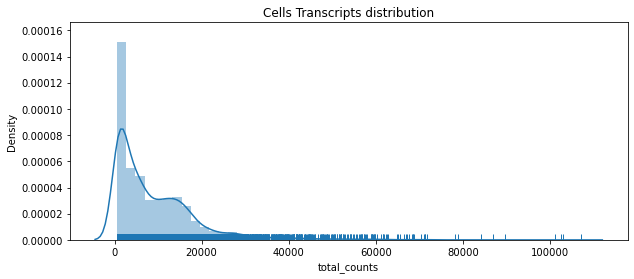

In [159]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
fig1 = sns.distplot(sample_2.obs['total_counts'], bins=50, rug=True)
title1 = ax.set_title('Cells Transcripts distribution')

Let's zoom in on the distribution by setting a limit on the x-axis. It is easier to see that 2500 could be a reasonable minimum threshold for the total number of transcripts.

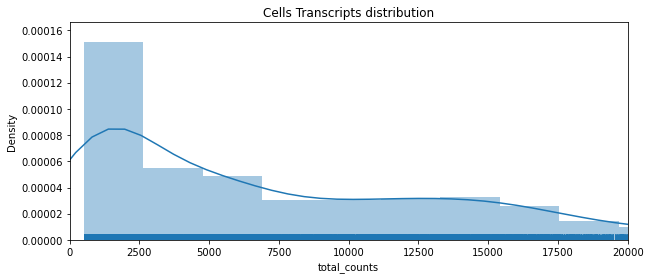

In [160]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
fig1 = sns.distplot(sample_2.obs['total_counts'], bins=50, rug=True)
plt.xlim(0, 20000)
title1 = ax.set_title('Cells Transcripts distribution')

Again we focus on the right area of the plot. Here it is easy to identify a maximum threshold where the tail of the distribution is really low. For example we can choose 35000 total transcripts.

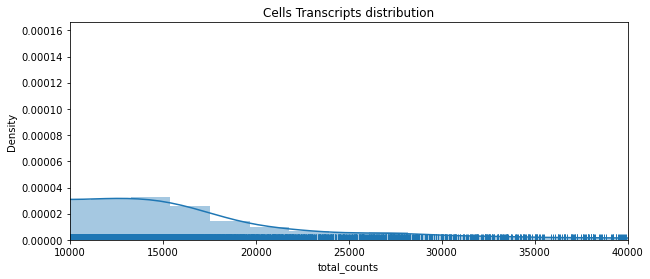

In [161]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
fig1 = sns.distplot(sample_2.obs['total_counts'], bins=50, rug=True)
plt.xlim(10000, 40000)
title1 = ax.set_title('Cells Transcripts distribution')

We do a similar analysis with the thresholds for the number of genes detected in each droplet. 

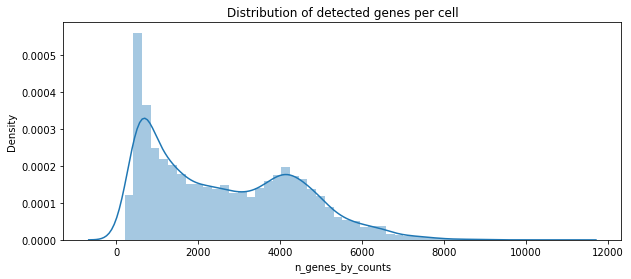

In [162]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
fig1 = sns.distplot(sample_2.obs['n_genes_by_counts'], bins=50)
title1 = ax.set_title('Distribution of detected genes per cell')

Here we can select a minimum threshold of 1000 to remove the lower peak from the distribution, and we can choose a maximum threshold of 7000.

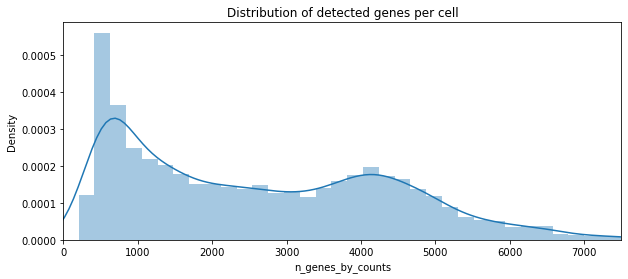

In [163]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
fig1 = sns.distplot(sample_2.obs['n_genes_by_counts'], bins=50)
plt.xlim(0, 7500)
title1 = ax.set_title('Distribution of detected genes per cell')

**Mitochondrial content**: In this dataset there are few cell with a high percentage of mitochondrial content. Those are precisely 245 if we set 0.1 (that is 10%) as a threshold. A value between 10% and 20% is the usual standard when filtering single cell datasets.

In [164]:
#subsetting to see how many cells have percentage of mitochondrial genes above 10%
sample_2[ sample_2.obs['perc_mito']>0.1, : ].shape

(245, 36601)

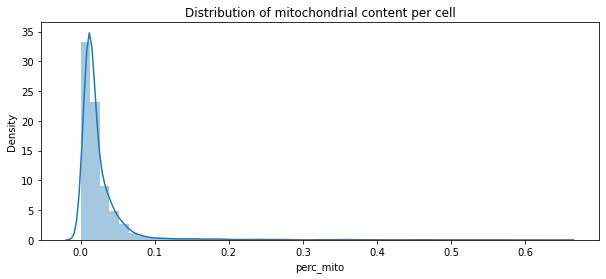

In [165]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
fig1 = sns.distplot(sample_2.obs['perc_mito'], bins=50)
title1 = ax.set_title('Distribution of mitochondrial content per cell')

Zooming in on mitochondrial content

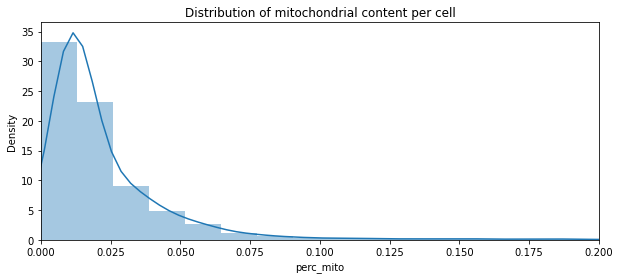

In [166]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
fig1 = sns.distplot(sample_2.obs['perc_mito'], bins=50)
plt.xlim(0, .2)
title1 = ax.set_title('Distribution of mitochondrial content per cell')

**Ribosomal content**: The percentage of ribosomal protein genes is higher than the one for mitochondrial genes. Here there is not a typical threshold, since this can change a lot amongst datasets and their biological characteristics. It is better tio choose a weak threshold when in doubt, for example setting a maximum boundary of 0.3.

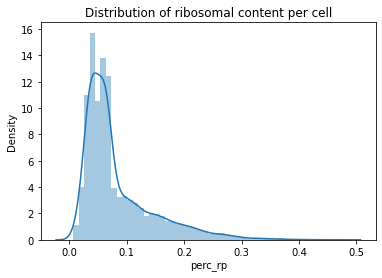

In [167]:
ax = sns.distplot(sample_2.obs['perc_rp'], bins=50)
x = ax.set_title('Distribution of ribosomal content per cell')

We can see how many droplets contain more than 30% of ribosomal protein transcripts

In [168]:
f'Max ribosomal transcript threshold overstepped by {sum(sample_2.obs["perc_rp"]>0.3)} cells'

'Max ribosomal transcript threshold overstepped by 78 cells'

### Bidimensional patterns

**Counts vs Genes:** this is a typical plot, where you look at the total transcripts per cells (x axis) and detected genes per cell (y axis). **Usually, those two measures grow together**. Points with many transcripts where the number of detected genes grows slowly might be multiplets (multiple cells sequenced together as one), while very few transcripts and genes denote the presence of only ambient RNA or very low quality sequencing of a cell. In the two plots below, dots (droplets) are coloured based on the percentage of mitochondrial and ribosomal transcripts. Note how a high proportion of the two percentages (light blue and yellow colour) is often on cells with very low number of transcripts and genes (bottom left corner of the plots).

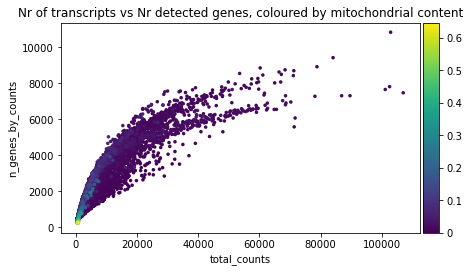

In [169]:
sc.pl.scatter(sample_2, x='total_counts', y='n_genes_by_counts', color='perc_mito', 
              title ='Nr of transcripts vs Nr detected genes, coloured by mitochondrial content',
             size=50)

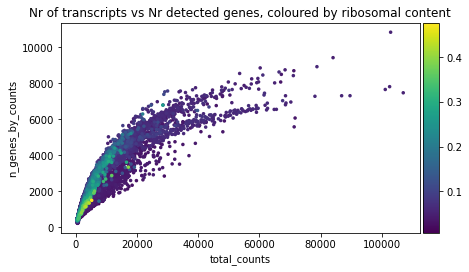

In [170]:
sc.pl.scatter(sample_2, x='total_counts', y='n_genes_by_counts', color='perc_rp', 
              title ='Nr of transcripts vs Nr detected genes, coloured by ribosomal content',
             size=50)

Looking at the bidimensional plots alone makes it hard to find proper thresholds for all the many parameters involved in the quality analysis. This is whywe have been looking at many different distributions and relationships between measures before.

### Abnormal amount of transcripts from a gene

Finally, we look at genes whose transcripts are prevalent in the cells of our data. The twenty top genes are in the barplot below. We can see PRM2, PRM1 and PTGDS are on the top three positions. However, those genes are prevalent in cells that are close to be developed spermatozoa, so their presence is not at all alarming in terms of data quality. The same holds for TNP1. Instead, we can take into consideration MALAT1 and the two mitochondrial genes MT-CO1 and MT-CO2, which are expressed at high percentages in many cells. This can be an indicator of cells with too low quality, because it means few genes are expressed while the others have low or zero expression.

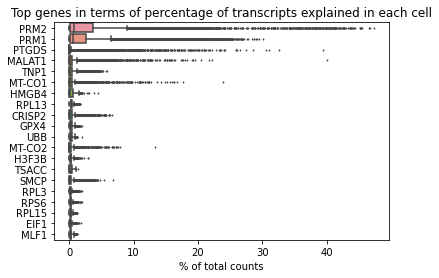

In [171]:
fig, ax = plt.subplots(1,1)
ax.set_title('Top genes in terms of percentage of transcripts explained in each cell')
fig = sc.pl.highest_expr_genes(sample_2, n_top=20, ax=ax)

We save the percentages of transcripts expressing the three genes identified above.

In [172]:
perc_malat = np.sum( sample_2[:,'MALAT1'].X, 1 ) / np.sum( sample_2.X, 1 )
sample_2.obs['perc_MALAT1'] = perc_malat.copy()

perc_malat = np.sum( sample_2[:,'MT-CO1'].X, 1 ) / np.sum( sample_2.X, 1 )
sample_2.obs['perc_MT-CO1'] = perc_malat.copy()

perc_malat = np.sum( sample_2[:,'MT-CO2'].X, 1 ) / np.sum( sample_2.X, 1 )
sample_2.obs['perc_MT-CO2'] = perc_malat.copy()

Note that, when the genes you suspect are indicating low-quality droplets are actually meaningful, you will see that high-percentages of transcripts match other low-quality indicators. For example, let's plot the three percentages defined above against the total amount of detected genes in each cell. You can see how droplets with fewer transcripts have at the same time high-percentages of mRNA from MALAT1, MT-CO1 and MT-CO2. You can use those plots to establish filtering thresholds. Below you can see some suggested thresholds plotted as red lines.

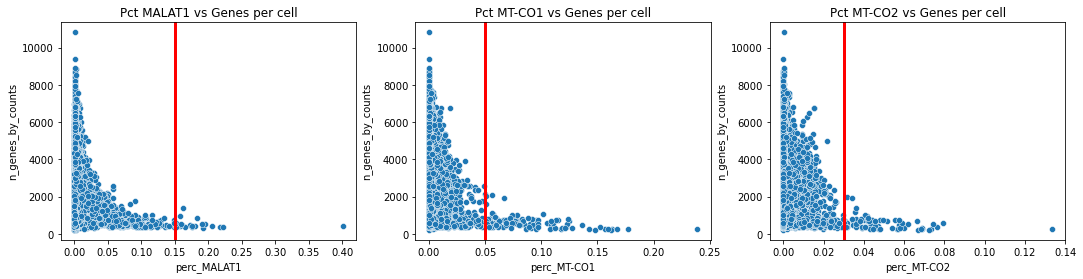

In [173]:
fig, ax = plt.subplots(1,3, figsize=(18,4))

#some thresholds based on the plots below
MALAT1_THR = 0.15
MTCO1_THR = 0.05
MTCO2_THR = 0.03

#ax.set_title('Top genes in terms of percentage of transcripts explained in each cell')
ax[0].set_title('Pct MALAT1 vs Genes per cell')
fig1 = sns.scatterplot( x=sample_2.obs['perc_MALAT1'], y=sample_2.obs['n_genes_by_counts'], ax=ax[0] )
fig1.axvline(x=MALAT1_THR, lw=3, c='r')
ax[1].set_title('Pct MT-CO1 vs Genes per cell')
fig2 = sns.scatterplot( x=sample_2.obs['perc_MT-CO1'], y=sample_2.obs['n_genes_by_counts'], ax=ax[1] )
fig2.axvline(x=MTCO1_THR, lw=3, c='r')
ax[2].set_title('Pct MT-CO2 vs Genes per cell')
fig3 = sns.scatterplot( x=sample_2.obs['perc_MT-CO2'], y=sample_2.obs['n_genes_by_counts'], ax=ax[2] )
fig3.axvline(x=MTCO2_THR, lw=3, c='r')

How many cells would we remove with these thresholds?

In [174]:
#find droplets above one of the thresholds
total = (sample_2.obs['perc_MALAT1']>MALAT1_THR)|(sample_2.obs['perc_MT-CO1']>MTCO1_THR)|(sample_2.obs['perc_MT-CO2']>MTCO2_THR)

#save the identifier into the data
sample_2.obs['genes_threshold_filter'] = pd.Categorical(total).copy()

In [175]:
#count all the cells above thresholds
f'You will filter out in total {sum(total)} cells'

'You will filter out in total 145 cells'

### PCA-based outlier detection

Choosing thresholds is much of a visual exercise, and thus subject to our own feeling of what is a true cell or a droplet not worth including in the data analysis. A good strategy that can be adopted is to **choose quite permissive thresholds and let an automatic procedure finding the remaining outliers** based on quality measures. Here, we calculate the PCA of all available quality measures and find outliers within the PCA projection. This method sometimes fails, especially when your data is of very good or extremely bad quality, selecting an enormous amount of cells as outliers. Thus always look at the diagnostic plots below to see if only a reasonable amount of points is selected as outlying in the data. This is an exact reproduction of the PCA filtering implemented in the `scater` package ([McCarthy et al, 2017](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5408845/))

--- PCA of dimension 2 on the following metadata:
['log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'perc_rp', 'perc_mito', 'perc_MT-CO1', 'perc_MALAT1', 'perc_MT-CO2']
on a sample with 8583 datapoints
--- Calculate outlyingness on 100 randomly sampled axae, (random seed 42)
--- Found 924 outliers
--- Returned annotated data object containing
--- * adata.obs["SDO_outliers"]: boolean variable identifying outliers
--- * adata.obs["SDO_outlyingness"]: outlyingness of each cell


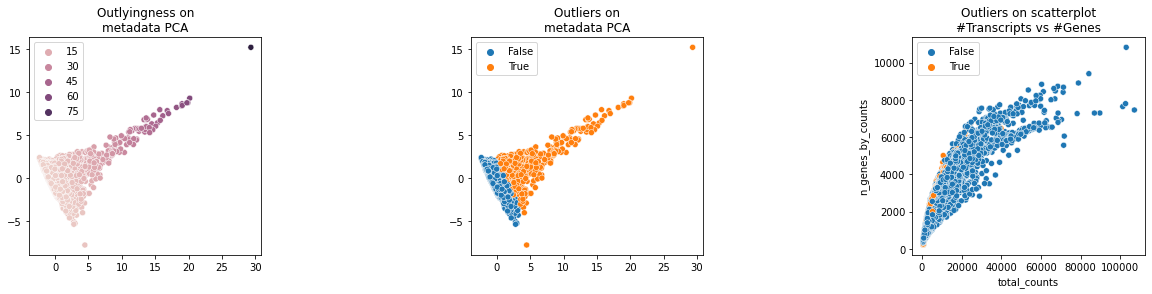

In [176]:
sample_2 = PCAfiltering(adata=sample_2, 
                     obs_subset=['log1p_n_genes_by_counts','log1p_total_counts', 
                                 'pct_counts_in_top_50_genes', 'perc_rp', 'perc_mito',
                                 'perc_MT-CO1', 'perc_MALAT1', 'perc_MT-CO2']) 

The algorithm found 924 outliers. Those are saved in `sample_2.obs["SDO_outliers"]`. Do those match some of the outliers found with the percentages of transcripts from `MALAT1`, `MT-CO1` and `MT-CO2`?

In [177]:
print('Number of outliers both from PCA and genes transcript percentage')
sum( np.bool8(sample_2.obs["SDO_outliers"]) & np.bool8(sample_2.obs["genes_threshold_filter"]) )

Number of outliers both from PCA and genes transcript percentage


128

In [178]:
print('Number of outliers only from PCA')
sum( np.bool8(sample_2.obs["SDO_outliers"]) )

Number of outliers only from PCA


924

In [179]:
print('Number of outliers only from genes transcript percentage')
sum( np.bool8(sample_2.obs["genes_threshold_filter"]) )

Number of outliers only from genes transcript percentage


145

This means that PCA finds outliers that include some of our previous criteria. We can also see in a scatter plot where the PCA-based filtering will remove cells.

Trying to set attribute `.uns` of view, copying.


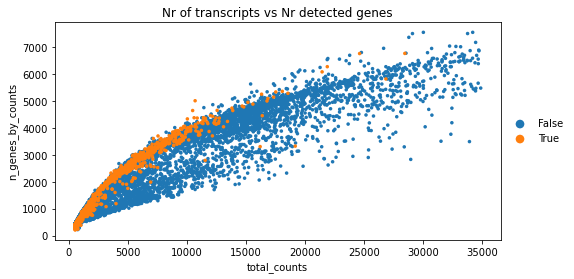

In [180]:
fig, ax = plt.subplots(1,1, figsize=(8,4))

#plot cells filtered by max transcripts
fig1 = sc.pl.scatter(sample_2[ sample_2.obs['total_counts']<MAX_COUNTS ],
             x='total_counts', y='n_genes_by_counts', color='SDO_outliers', size=50,
              title =f'Nr of transcripts vs Nr detected genes', ax=ax)

## Choosing thresholds and filtering

We now establish all the filtering values discussed until now by looking at distributions.

In [181]:
MIN_COUNTS = 2500  #minimum number of transcripts per cell
MAX_COUNTS = 35000 #maximum number of transcripts per cell
MIN_GENES = 1000   #minimum number of genes per cell
MAX_GENES = 7000   #maximum number of genes per cell
MAX_MITO = .1      #mitochondrial percentage threshold
MAX_RP = .3       #ribosomal percentage threshold

We can also plot all the points we are going to filter out. We save `all_filters` in the data. This contains all filters defined until now to detect points to remove.

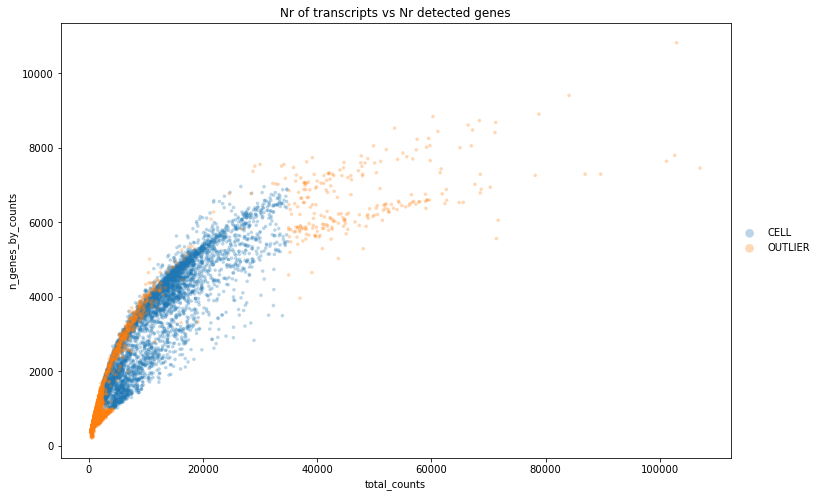

In [182]:
all_filters = (sample_2.obs['total_counts']>MAX_COUNTS) | (sample_2.obs['total_counts']<MIN_COUNTS) | \
              (sample_2.obs['n_genes_by_counts']<MIN_GENES) | (sample_2.obs['n_genes_by_counts']>MAX_GENES) | \
              np.bool8(sample_2.obs['genes_threshold_filter']) | np.bool8(sample_2.obs['SDO_outliers']) | \
              (sample_2.obs['perc_mito']>MAX_MITO) | (sample_2.obs['perc_mito']>MAX_RP)

sample_2.obs['all_filters'] = pd.Categorical(all_filters).rename_categories(['CELL','OUTLIER'])
            
fig, ax = plt.subplots(1,1, figsize=(12,8))

#plot cells filtered by max transcripts
fig1 = sc.pl.scatter(sample_2, alpha=.3,
             x='total_counts', y='n_genes_by_counts', color='all_filters', size=50,
              title =f'Nr of transcripts vs Nr detected genes', ax=ax, )

**Important**: After filtering, we will normalize the data and plot projections, identify clusters and perform other analysis. In such steps, one might find out that there are groups of low quality data points (for example, large unidentifiable clusters of cells with less transcripts than in all the other clusters). In that case it is good to go back to filtering and be more conservative in choosing threshold parameters.

 
The following commands filter using all the chosen thresholds defined before. Note for the second filtering: the parameter `min_cells` remove all those cells showing transcripts for only 10 genes or less - standard values for this parameter are usually between 3 and 10, and do not come from looking at the QC plots. This is just to remove very rare transcripts that are meaningless in a downstream analysis. Note that this means we will not find clusters of cells containing 10 cells or less.

In [193]:
sample_2 = sample_2[ sample_2.obs['all_filters'] == "CELL" ].copy()

sc.preprocessing.filter_genes(sample_2, min_cells=10)

We can see here the new data size

In [194]:
print(f'Cells after filters: {sample_2.shape[0]}, Genes after filters: {sample_2.shape[1]}')

Cells after filters: 5000, Genes after filters: 24531


## Doublet filtering

Another important step consists in filtering out multiplets. Those are in the almost totality of the cases doublets, because triplets and above multiplets are extremely rare. Read [this more technical blog post](https://liorpachter.wordpress.com/2019/02/07/sub-poisson-loading-for-single-cell-rna-seq/) for more explanations about this.

The external tool `scrublet` simulates doublets by putting together the transcripts of random pairs of cells from the dataset. Then it assigns a score to each cell in the data, based on the similarity with the simulated doublets. 

![](https://ars.els-cdn.com/content/image/1-s2.0-S2405471218304745-fx1.jpg)

*Figure: the `scrublet` working principle, from (Wolock et al, 2019)*

An `expected_doublet_rate` of 0.06 (6%) is quite a typical value for single cell data, but if you have a better estimate from laboratory work, microscope imaging or a specific protocol/sequencing machine, you can also tweak the value. 
`random_state` is a number choosing how the simulations are done. Using a specific random state means that you will always simulate the same doublets whenever you run this code. This allows you to reproduce exactly the same results every time and is a great habit to have for reproducibility in your own research.

In [150]:
 sc.external.pp.scrublet(sample_2, 
                        expected_doublet_rate=0.06,
                        random_state=12345)

Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.6%
Estimated detectable doublet fraction = 56.9%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 2.9%


It seems that the doublet rate is likely to be lower than 6%, meaning that, in this regard, the data has been produced pretty well. We now plot the doublet scores assigned to each cell by the algorithm. We can see that most cells have a low score (the score is a value between 0 and 1). Datasets with many doublets show a more bimodal distribution (look for example at [this example](https://github.com/swolock/scrublet/blob/master/examples/scrublet_basics.ipynb) from the `scrublet` tutorial), while here we just have a light tail beyond 0.1. 

<AxesSubplot:xlabel='doublet_score', ylabel='Density'>

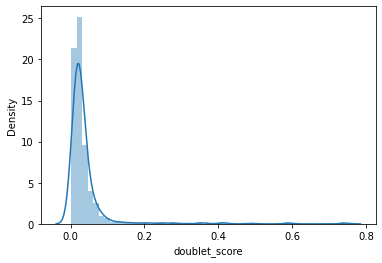

In [151]:
sns.distplot(sample_2.obs['doublet_score'])

We can choose 0.1 as filtering threshold for the few detected doublets or alternatively use the automatic selection of doublets by the algorithm. We will choose the last option and use the automatically chosen doublets.

In [152]:
sample_2 = sample_2[np.invert(sample_2.obs['predicted_doublet'])].copy()

In [153]:
print(f'Cells after filters: {sample_2.shape[0]}, Genes after filters: {sample_2.shape[1]}')

Cells after filters: 3492, Genes after filters: 24343


## Dependence of the data on technical features

In [233]:
# TPM normalization
sample_2.X = sample_2.layers['umi_raw'].copy()
sc.pp.normalize_per_cell(sample_2)
sc.pp.log1p(sample_2)
sc.pp.highly_variable_genes(sample_2, n_top_genes=5000)
#sc.pp.scale(sample_2)
sample_2.X = sample_2.layers['umi_raw'].copy()
sc.preprocessing.pca(sample_2, svd_solver='arpack', random_state=12345)

In [236]:
X

array([[-4.96198364e+02,  8.84696469e-03],
       [-5.45286316e+02,  1.31677482e-02],
       [-5.43337097e+02,  1.70335062e-02],
       ...,
       [-5.39945984e+02,  2.87439805e-02],
       [ 1.10634473e+03,  8.18858575e-03],
       [ 4.58644189e+03,  3.87299503e-03]])

0.30167600431158903

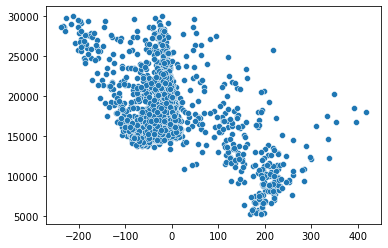

In [282]:
from sklearn.linear_model import LinearRegression as LR

y='total_counts'
PC = 3



X = np.zeros([sample_2.shape[0],2])
X[:,0] = sample_2.obsm['X_pca'][:,PC]
X[:,1] = sample_2.obs[y]

sns.scatterplot(x=X[:,0], y=X[:,1])

reg = LR().fit(X[:,0].reshape(-1,1), X[:,1].reshape(-1,1))
pred = reg.predict(X[:,0].reshape(-1,1))
from sklearn.metrics import mean_squared_error, r2_score
r2_score(X[:,1], pred)

0.6821096023812049

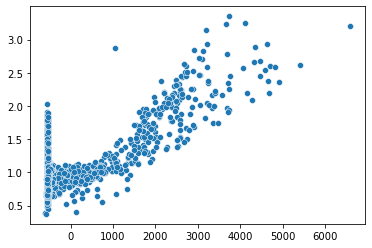

In [311]:
from sklearn.linear_model import LinearRegression as LR

y='SDO_outlyingness'
PC = 0

X = np.zeros([sample_2.shape[0],2])
X[:,0] = sample_2.obsm['X_pca'][:,PC]
X[:,1] = sample_2.obs[y]

sns.scatterplot(x=X[:,0], y=X[:,1])

reg = LR().fit(X[:,0].reshape(-1,1), X[:,1].reshape(-1,1))
pred = reg.predict(X[:,0].reshape(-1,1))
from sklearn.metrics import mean_squared_error, r2_score
r2_score(X[:,1], pred)

In [246]:
reg.coef_

array([-2.14339915e-16,  1.00000000e+00])

In [221]:
sc.pp.log1p(sample_2)
data = sc.pp.regress_out(sample_2, keys=['perc_mito','total_counts'], copy=True, n_jobs=4)

In [222]:
sample_2.layers['umi_regress'] = data.X.copy()

In [223]:
sample_2.X = sample_2.layers['umi_regress'].copy()

In [224]:
sample_2.X

array([[-5.0475043e-03,  4.3037557e-04,  9.4468492e-01, ...,
        -3.4339190e-02,  7.0794779e-03,  1.1322396e+00],
       [-4.8224875e-03,  4.0695395e-05,  5.0287622e-01, ...,
        -4.9332839e-02,  2.3607381e-03, -4.1303363e-01],
       [-4.5510512e-03,  3.0204075e-04,  1.6995846e-01, ...,
        -3.1191384e-02,  1.0057619e-02, -3.3356413e-01],
       ...,
       [-4.0811403e-03, -1.9715766e-03, -3.5768741e-01, ...,
        -1.3481128e-01, -2.6520031e-02, -2.0369458e-01],
       [-5.6734681e-03, -4.6576778e-03,  3.3221790e-01, ...,
        -2.9834324e-01, -9.2778265e-02,  4.2546436e-01],
       [-6.0808561e-03, -5.8573950e-03, -1.7031007e-01, ...,
        -3.6556664e-01, -1.1911162e-01,  5.9159040e-01]], dtype=float32)

## Evaluation of filtering

A quite basic but easy way to look at the results of our filtering is to normalize and plot the dataset on some projections. Here we use a standard normalization technique that consists of:
- **TPM normalization**: the transcripts of each cell are normalized, so that their total amounts to the same value in each cell. This should make cells more comparable independently of how many transcripts has been retained during cell isolation.
- **Logarithmization**: the logarithm of the normalized transcripts is calculated. This reduce the variability of transcripts values and highlights variations due to biological factors.
- **Standardization**: Each gene is standardized across all cells. This is useful for example  for projecting the data onto a PCA. 

Do not worry about these steps, we will explain them in more detail in the next lessons

In [225]:
# TPM normalization and storage of the matrix
#sc.pp.normalize_per_cell(sample_2)
#sample_2.layers['umi_tpm'] = sample_2.X.copy()

# Logarithmization and storage
#sc.pp.log1p(sample_2)
#sample_2.layers['umi_log'] = sample_2.X.copy()

# Select some of the most meaningful genes to calculate the PCA plot later
# This must be done on logarithmized values
sc.pp.highly_variable_genes(sample_2, n_top_genes=2000)

# save the dataset
sample_2.write('../../Data/notebooks_data/sample_2.filt.h5ad')

# standardization and matrix storage
#sc.pp.scale(sample_2)
sample_2.layers['umi_gauss'] = sample_2.X.copy()

Now we calculate the PCA projection

In [226]:
sc.preprocessing.pca(sample_2, svd_solver='arpack', random_state=12345)

We can look at the PCA plot and color it by some quality measure and gene expression. We can already see how the PCA has a clear structure with only a few dots sparsed around. It seems the filtering has got a good result.

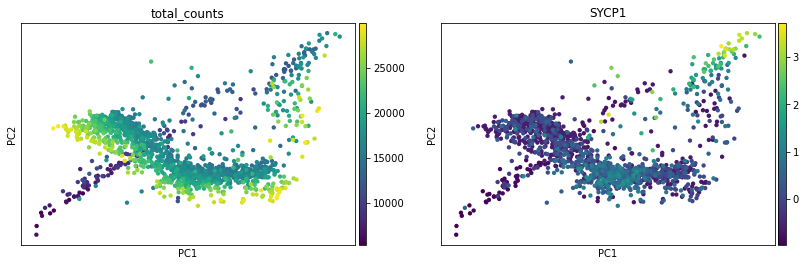

In [227]:
sc.pl.pca(sample_2, color=['total_counts','SYCP1'])

We plot the variance ratio to see how each component of the PCA changes in variability. Small changes in variability denote that the components are mostly modeling noise in the data. We can choose a threshold (for example 15 PCA components) to be used in all algorithms that use PCA to calculate any quantity.

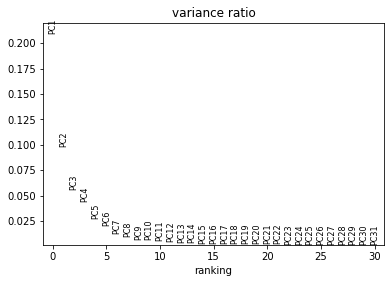

In [228]:
sc.plotting.pca_variance_ratio(sample_2)

We project the data using the UMAP algorithm. This is very good in preserving the structure of a dataset in low dimension, if any is present. We first calculate the neighbors of each cell (that is, its most similar cells), those are then used for the UMAP. The neighbors are calculated using the PCA matrix instead of the full data matrix, so we can choose the number of PCA components to use (parameter `n_pcs`). Many algorithms work on the PCA, so you will see the parameter used again in other places.

In [229]:
sc.pp.neighbors(sample_2, n_pcs=15, random_state=12345)

In [230]:
sc.tools.umap(sample_2, random_state=54321)

The UMAP plot gives a pretty well-structured output for this dataset. We will keep working further with this filtering.

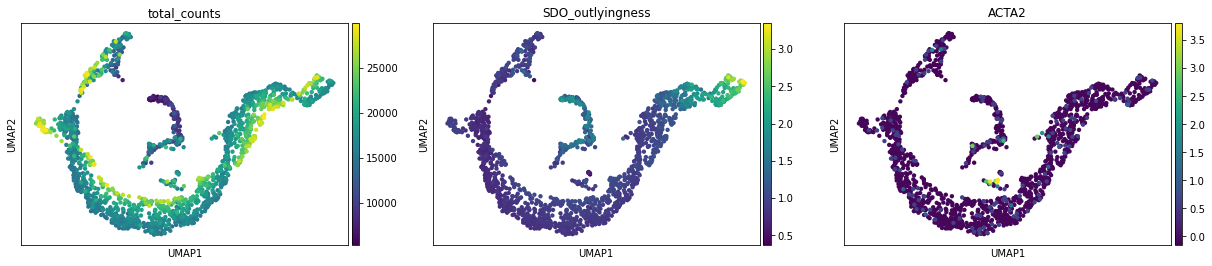

In [231]:
sc.plotting.umap(sample_2, color=['total_counts','SDO_outlyingness', 'ACTA2'])

In [232]:
sample_2.write('../../Data/notebooks_data/sample_2.filt.norm.h5ad')

-------------------------------

## Wrapping up

We have succesfully gone through the filtering of a single cell dataset with good results that can be used further in the data analysis. In the next notebook Normalize and Integrate, we will integrate this dataset (testis cells from a healthy adult man) with the same type of sample from another man. Filtering of the other dataset is in the notebook `Part02_filtering_sample3.ipynb`. **Run the notebook to generate the filtered dataset**. The procedure follows tightly what happens for the dataset we just filtered.

-------------

**Optional:** 

As you could see, this dataset seemed pretty ok to handle. There is another dataset of much lower quality, but will not be integrated in the coming data analysis. Its preprocessing is shown as the submenu `Filtering a low quality sample` in the section `Extra` of the course webpage. In it, we will also show an aggressive filtering workflow using a combination of PCA and automatic outliers detection. Feel free to explore it!